<a href="https://colab.research.google.com/github/yuncaich/TFG_Proyect/blob/main/TFG/medMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist

     |████████████████████████████████| 87 kB 3.5 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=000063f25fefd8e137d1a53526c498da44818af7af705a126054ee7cecbdfc98
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
data_flag = 'dermamnist'

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = info['label']

DataClass = getattr(medmnist, info['python_class'])



In [5]:
info['python_class']

'DermaMNIST'

In [6]:
lista = [*n_classes.values()]

In [7]:
#normalize
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)
pil_dataset = DataClass(split='train', download=True)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/19725078 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [8]:
test_dataset


Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root location: /root/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0

In [9]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=0.25, gamma=2, size_average = True):
    super(FocalLoss, self).__init__()
    self.size_average = size_average
    self.alpha = alpha
    self.gamma = torch.Tensor([gamma])
    if isinstance(alpha, (float, int)):
      if self.alpha > 1:
        raise ValueError('Not supported value, alpha should be small than 1.0')
      else:
        self.alpha = torch.Tensor([alpha, 1.0 - alpha])
    if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
    self.alpha /= torch.sum(self.alpha)

  def forward(self, input, target):
    input= torch.softmax(input,dim=1)
    if input.dim() > 2:
      input = input.view(input.size(0), input.size(1), -1)
      if self.alpha.device != input.device:
            self.alpha = torch.tensor(self.alpha, device=input.device)
    target = target.view(-1, 1)
    logpt = torch.log(input + 1e-10)
    logpt = logpt.gather(1, target)
    logpt = logpt.view(-1, 1)
    pt = torch.exp(logpt)
    alpha = self.alpha.gather(0, target.view(-1))
 
    gamma = self.gamma
 
    if not self.gamma.device == input.device:
      gamma = torch.tensor(self.gamma, device=input.device)
 
    loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt
    if self.size_average:
      loss = loss.mean()
    else:
      loss = loss.sum()
    return loss
    
    

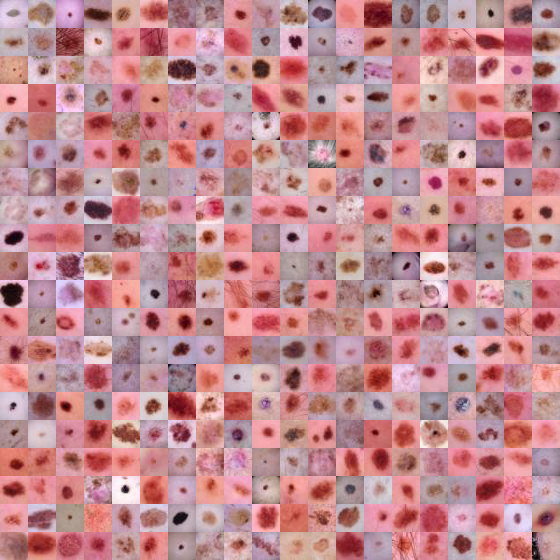

In [10]:
# visualization

#train_dataset.montage(length=40)

from matplotlib import pyplot
import numpy as np

train_dataset.montage()

In [25]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, len(num_classes)))
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

criterion = nn.CrossEntropyLoss()
#criterion = FocalLoss([1/7]*7)

    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [12]:
criterion.alpha

tensor([0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429])

In [13]:
#print(targets.shape)
#torch.unique(targets)
#print(outputs.shape)

In [14]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
            
        if task == 'multi-label, binary-class':
                targets = targets.to(torch.int64)
                loss = criterion(outputs, targets)
        else:
                loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        #print( "Train epoch  : {} \t Loss : {:.6f}".format(epoch , loss.item()))

100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


==> Evaluating ...
tensor([[0.0262, 0.0403, 0.1052, 0.0135, 0.1511, 0.6474, 0.0163],
        [0.0192, 0.0332, 0.0784, 0.0094, 0.1634, 0.6853, 0.0111],
        [0.0242, 0.0362, 0.0984, 0.0131, 0.1865, 0.6265, 0.0151],
        [0.0255, 0.0358, 0.0998, 0.0111, 0.1748, 0.6394, 0.0135],
        [0.0455, 0.0651, 0.1558, 0.0267, 0.2039, 0.4733, 0.0297],
        [0.0427, 0.0682, 0.1939, 0.0270, 0.2179, 0.4210, 0.0294],
        [0.0148, 0.0248, 0.0670, 0.0071, 0.1666, 0.7110, 0.0087]])
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

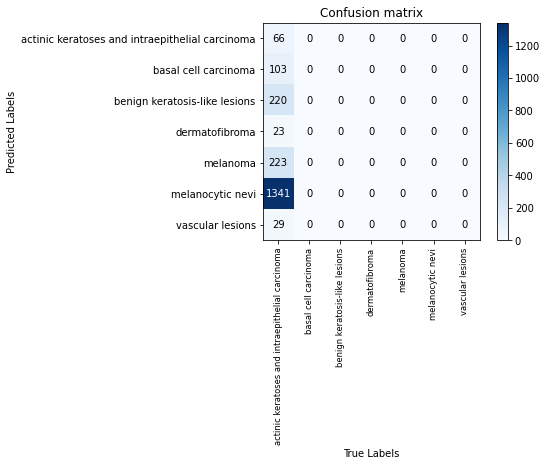

The model accuracy is 0.03291770573566085
+-------------------------------------------------+-----------+--------+-------------+
|                                                 | Presicion | Recall | Specificity |
+-------------------------------------------------+-----------+--------+-------------+
| actinic keratoses and intraepithelial carcinoma |    1.0    | 0.033  |     nan     |
|               basal cell carcinoma              |    0.0    |  nan   |    0.949    |
|          benign keratosis-like lesions          |    0.0    |  nan   |     0.89    |
|                  dermatofibroma                 |    0.0    |  nan   |    0.989    |
|                     melanoma                    |    0.0    |  nan   |    0.889    |
|                 melanocytic nevi                |    0.0    |  nan   |    0.331    |
|                 vascular lesions                |    0.0    |  nan   |    0.986    |
+-------------------------------------------------+-----------+--------+-------------+


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


In [24]:
# evaluation
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    test_loss = 0.0
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    labels = [label for _,label in n_classes.items()]
    confusion = ConfusionMatrix(len(n_classes) , labels)

    with torch.no_grad():
        for inputs, targets in data_loader:

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            targets = targets.to(torch.int)
            confusion.update(outputs.numpy(),targets.numpy())

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        targets = targets.to(torch.int64)
        test_loss += criterion(outputs, targets).item()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print(outputs[:7])
        print(torch.argmax(outputs,dim=1))
        #print(test_loss)
        #matc=confusion_matrix(y_true, y_score[0])
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        
        confusion.plot()
        confusion.summary()
        
        
print('==> Evaluating ...')
#test('train')
test('test')



In [23]:
model

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

In [15]:
from prettytable import PrettyTable
import matplotlib.pyplot as plt

class ConfusionMatrix(object):

  def __init__(self, num_classes: int, labels: list):
    self.matrix = np.zeros((num_classes,num_classes))
    self.num_classes = num_classes
    self.labels = labels

  def update(self, preds, labels):
    for p, t in zip(preds, labels):
      p = p.astype(int)
      t = t.astype(int)
      self.matrix[t,p] += 1

  def summary(self):
    #calcular accuracy
    sum_TP = 0
    for i in range(self.num_classes):
      sum_TP += self.matrix[i,i]
      
    acc = sum_TP/np.sum(self.matrix)
    print("The model accuracy is" , acc)

     #Presicion, recal, specificity
    table = PrettyTable()
    table.field_names = ["", "Presicion", "Recall", "Specificity"]

    for i in range (self.num_classes):
      TP = self.matrix[i,i]
      FP = np.sum(self.matrix[i, :]) - TP
      FN = np.sum(self.matrix[:, i]) - TP
      TN = np.sum(self.matrix) - TP - FP - FN

      Presicion = round(TP / (TP + FP), 3)
      Recall = round(TP / (TP + FN), 3)
      Specificity = round(TN / (TN + FP), 3)

      table.add_row([self.labels[i],Presicion,Recall,Specificity])
      
    print(table)
    
  def plot(self):
    matrix = self.matrix

    print(matrix) 

    plt.imshow(matrix , cmap=plt.cm.Blues)
      
    #X label 
    plt.xticks(range(self.num_classes) , self.labels, rotation=90 , size = "small")
      
    #y label

    plt.yticks(range(self.num_classes) , self.labels)

    #显示 colorbar
    plt.colorbar()
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title("Confusion matrix")

      #标注数量 & 概率信息

    thresh = matrix.max() / 2
    for x in range (self.num_classes):  #columnas
      for y in range(self.num_classes):  #fila
        info = int(matrix[y,x])
        plt.text(x, y, info,                    #escribir valor
                    verticalalignment ='center',
                    horizontalalignment ='center',
                    color = "white" if info > thresh else "black")
          
    ##plt.tight_layout()
    plt.show()



    
      

In [ ]:
len(n_classes)

In [ ]:
labels = [label for _,label in n_classes.items()]
